# 📈 **GRAPHS ALGORITHMS GENERATOR** 

---------------------------
### **IMPORTS**

In [1]:
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import numpy as np
import numbers
import matplotlib.pyplot as plt
import pandas as pds
from itertools import cycle

from copy import deepcopy
import csv

import time
import os
import sys

#from LAMDA_SSL.Algorithm.Classification.Tri_Training import Tri_Training as TriTrainingLamda

from sslearn.wrapper import TriTraining as TriTrainingSSLearn
from sslearn.model_selection import artificial_ssl_dataset
from sslearn.base import get_dataset

src_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(src_path)
from classifiers.CoForestClassifier import CoForest
from classifiers.TriTrainingClassifier import TriTraining
from notebooks.graphs_utils import *

---------------------------
### **CLASSES**

Fit methods needs to be overwritten since graphs are generated while training, so inheritance is used.

In [4]:
class CoForest_graphs(CoForest):

    def fit(self, L, y, U, X_test, y_test):
        """
        Fits the ensemble using both labeled and
        pseudo-labeled data. Generates graphs to show 
        how score evolves during training.

        Parameters
        ----------
        L: np.array
            Labeled data used for training
        y: np.array
            Tags of the labeled data used for training
        U: np.array
            Unlabeled data used for training
        X_test: np.array
            samples to check evolution
        y_test: np.array
            labels of samples to check evolution
        """

        mask_L = self.create_trees(L, y)
        scores = [self.score(X_test, y_test)]

        e = [0 for i in range(self.n)]
        W = [0 for i in range(self.n)]

        previous_e = [0.5 for i in range(self.n)]
        previous_W = [min(0.1*len(L), 100) for i in range(self.n)]

        new_data = True
        t = 0

        while new_data:

            t += 1
            tree_changes = np.array([False for i in range(self.n)])
            tree_pseudo_updates = [() for i in range(self.n)]

            for i, hi in self.ensemble.items():

                e[i] = self.concomitant_oob_error(hi, L, y, mask_L)
                W[i] = previous_W[i]
                pseudo_labeled_data = []
                pseudo_labeled_tags = []

                if e[i] < previous_e[i]:

                    if e[i] == 0:
                        Wmax = self.theta * U.shape[0]
                    else:
                        Wmax = min(self.theta * U.shape[0], ((previous_e[i]*previous_W[i])/e[i]) )

                    U_subsampled = self.subsample(hi, U, Wmax) 
                    W[i] = 0

                    for u in U_subsampled:
                        concomitant_confidence, selected_class = self.concomitant_confidence(hi, U[u, :])

                        if concomitant_confidence > self.theta:
                            tree_changes[i] = True
                            pseudo_labeled_data.append(U[u, :])
                            pseudo_labeled_tags.append(selected_class)
                            W[i] += concomitant_confidence

                tree_pseudo_updates[i] = ( (np.array(pseudo_labeled_data), np.array(pseudo_labeled_tags) ) )

            for i in np.fromiter(self.ensemble.keys(), dtype=int)[tree_changes]:
                if e[i] * W[i] < previous_e[i] * previous_W[i]:
                    self.retrain_tree(i, L, y, tree_pseudo_updates[i][0], tree_pseudo_updates[i][1], mask_L)

            previous_e = deepcopy(e)
            previous_W = deepcopy(W)

            if tree_changes.sum() == 0:
                new_data = False

            scores.append(self.score(X_test, y_test))

        append_to_csv("file.csv", scores)

In [5]:
import numpy as np
import numbers
from math import floor, ceil

class TriTraining_graphs(TriTraining):  

    def fit(self, L, y, U, X_test, y_test):
        """
        Trains the tri-training ensemble using Zhi-Hua Zhou
        Algorithm. Generates graphs to show how score
        evolves during training.

        Parameters
        ----------
        L: np.array
            Labeled data used for training
        y: np.array
            Labeled data tags used for training
        U: np.array
            Unlabeled data used for training
        """

        self.initialize_classifiers(L, y)
        self.classes = np.unique(y)

        previous_e = [0.5 for i in range(self.n)]
        previous_l = [0.0 for i in range(self.n)]
        e = [0.0 for i in range(self.n)]
        new_data = True

        t = 0
        scores = [self.score(X_test, y_test)]

        while new_data:

            t += 1
            cls_changes = np.array([False for i in range(self.n)])
            cls_pseudo_updates = [() for i in range(self.n)]

            for i in range(self.n):

                e[i] = self.measure_error(i, L, y)

                if e[i] < previous_e[i]:
                    cls_pseudo_updates[i] = self.create_pseudolabeled_set(i, U)

                    if previous_l[i] == 0:
                        previous_l[i] = floor((e[i] / (previous_e[i]-e[i])) + 1)

                    L_i_size = cls_pseudo_updates[i][0].shape[0]

                    if previous_l[i] < L_i_size:

                        if e[i] * L_i_size < previous_e[i] * previous_l[i]:
                            cls_changes[i] = True
                        
                        elif previous_l[i] > (e[i] / (previous_e[i] - e[i])):

                            L_index = self.rd.choice(L_i_size, ceil((previous_e[i] * previous_l[i] / e[i]) - 1))
                            cls_pseudo_updates[i] = (cls_pseudo_updates[i][0][L_index, :], cls_pseudo_updates[i][1][L_index])
                            cls_changes[i] = True

            if cls_changes.sum() == 0:
                new_data = False

            else:

                for i in np.fromiter(self.classifiers.keys(), dtype=int)[cls_changes]:

                    X_train = np.concatenate((L, cls_pseudo_updates[i][0]))
                    y_train = np.concatenate((y, cls_pseudo_updates[i][1]))
                    self.classifiers[i] = self.classifiers[i].fit(X_train, y_train)

                    previous_e[i] = e[i]
                    previous_l[i] = cls_pseudo_updates[i][0].shape[0] #Tamaño de Li anterior
                    
                scores.append(self.score(X_test, y_test))

        append_to_csv("file.csv", scores)

In [6]:
def create_base_cls(algorithm, n = 6, thetha = 0.75, max_features = 'log2', rd = np.random.RandomState(10)):

    if algorithm == 'CF':
        return CoForest(n, thetha, max_features, random_state = rd)

    elif algorithm == 'CFG':
        return CoForest_graphs(n, thetha, max_features, random_state = rd)
    
    elif algorithm == 'TT':
        return TriTraining(DecisionTreeClassifier(), GaussianNB(), KNeighborsClassifier(), rd)

    elif algorithm == 'TTG':
        return TriTraining_graphs(DecisionTreeClassifier(), GaussianNB(), KNeighborsClassifier(), rd)

----------------------------
# **GENERAL GRAPHS**

---------------------------------------------------
### **score - número de iteraciones (entrenamiento)**

In [8]:
def graph_score_iterations_train(algorithm = 'CF', rd_number = 5):

    fig, ax = plt.subplots()
    cycol = cycle('bgrcmk')
    next(cycol)
    available = [(load_iris(), 'Iris'), (load_digits(), 'Dígitos'), (load_wine(), 'Vino'), (load_breast_cancer(), 'Cáncer de mama')]

    for dataset_info in available:

        dataset = dataset_info[0]
        open('file.csv', 'w').close()
        X = np.array(dataset.data)
        y = np.array(dataset.target)
        rd = np.random.RandomState(rd_number)
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)

        for train_index, test_index in skf.split(X, y):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            L_train, U_train, Ly_train, Uy_train = train_test_split(X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)
            cls = create_base_cls(algorithm + 'G', n=20, rd=rd)
            cls.fit(L_train, Ly_train, U_train, X_test, y_test) #Test used to evaluate how score changes during training

        mean = np.mean(create_graph_matrix("file.csv"), axis=0)
        # ax.set_ylim([0.7, 1.05])
        ax.plot(np.arange(len(mean)), mean, '-o', color = next(cycol), label = dataset_info[1])

    #plt.title("Score - Iteraciones")
    ax.set_ylabel('score')
    ax.set_xlabel('iteraciones')
    plt.legend(loc="lower right")
    plt.show()

In [9]:
def graph_score_iterations_train_dsv(algorithm = 'CF', rd_number = 5):

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    cycol = cycle('bgrcmk')
    next(cycol)
    available = [(load_iris(), 'Iris', (0,0)), (load_digits(), 'Dígitos', (0,1)), (load_wine(), 'Vino', (1,0)), (load_breast_cancer(), 'Cáncer de mama', (1,1))]

    for dataset_info in available:

        open('file.csv', 'w').close()
        dataset = dataset_info[0]
        X = np.array(dataset.data)
        y = np.array(dataset.target)
        rd = np.random.RandomState(rd_number)
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            L_train, U_train, Ly_train, Uy_train = train_test_split(X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)
            cls = create_base_cls(algorithm + 'G', n = 20, rd = rd)
            cls.fit(L_train, Ly_train, U_train, X_test, y_test) #Test used to evaluate how score changes during training

        mean = np.mean(create_graph_matrix("file.csv"), axis = 0)
        std = np.std(create_graph_matrix("file.csv"), axis = 0)

        coordinates = dataset_info[2]
        ax_i = ax[coordinates[0], coordinates[1]]
        ax_i.set_ylim([0.7, 1.05])
        ax_i.errorbar(np.arange(len(mean)), mean, yerr=[std, np.minimum(std, 1-mean)], fmt='-o', color = next(cycol), label = dataset_info[1])
        ax_i.set_ylabel('score')
        ax_i.set_xlabel('iteraciones')
        ax_i.set_title(dataset_info[1])
        
    plt.show()

------------------------------------------------
### **número elementos - tiempo entrenamiento**


In [10]:
def graph_number_elem_training_time(algorithm = 'CF', rd_number = 10):

    cycol = cycle('bgrcmk')
    fig, ax = plt.subplots()
    cycol = cycle('bgrcmk')
    next(cycol)
    next(cycol) 

    dataset_info = (load_digits(), 'Dígitos')
    dataset = dataset_info[0]

    instancias = []
    tiempos = []
    rd = np.random.RandomState(rd_number)

    for i in range(500, dataset.data.shape[0], 100):

        indexes = rd.choice(dataset.data.shape[0], replace = True, size=i)

        X = np.array(dataset.data)[indexes]
        y = np.array(dataset.target)[indexes]
        L_train, U_train, Ly_train, Uy_train = train_test_split(X, y, test_size=0.8, random_state=rd)

        cls = create_base_cls(algorithm, n=20, rd=rd)
        inicio = time.time()
        cls.fit(L_train, Ly_train, U_train)
        fin = time.time()

        instancias.append(X.shape[0])
        tiempos.append((fin-inicio))

    ax.scatter(instancias, tiempos, color=next(cycol) )

    model = LinearRegression()
    model.fit(np.array([[i] for i in instancias]), tiempos)
    x_new = np.linspace(425, dataset.data.shape[0], 100)
    y_new = model.predict(x_new[:, np.newaxis])

    plt.title("Instancias - Tiempo entrenamiento")
    ax.set_ylim(bottom = 0)
    ax.plot(x_new, y_new, '--k')
    ax.set_xlabel('instancias')
    ax.set_ylabel('tiempo (s)')
    plt.show()

---------------------------------------------------
### **score - % instancias entrenamiento**

In [11]:
def score_percentage_training_instances(algorithm = 'CF', rd_number = 5, n_experiments = 10): 
    
    fig, ax = plt.subplots()
    cycol = cycle('bgrcmk')
    next(cycol)
    rd = np.random.RandomState(rd_number)
    available = [(load_iris(), 'Iris'), (load_digits(), 'Dígitos'), (load_wine(), 'Vino'), (load_breast_cancer(), 'Cáncer de mama')]

    for dataset_info in available:

        matriz_scores = []
        dataset = dataset_info[0]
        
        for j in range(n_experiments):
            scores_experimento = []

            for i in np.arange(0.5, 1, 0.1):
                X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, train_size=i, random_state=rd, stratify=dataset.target)
                L_train, U_train, Ly_train, Uy_train = train_test_split(X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)
                cls = create_base_cls(algorithm, n=20, rd=rd)
                cls.fit(L_train, Ly_train, U_train)
                scores_experimento.append(cls.score(X_test, y_test))

            matriz_scores.append(scores_experimento)

        ax.plot(np.arange(0.5, 1, 0.1), np.mean(np.array(matriz_scores), axis=0), '-o', color=next(cycol),  label=dataset_info[1])

    plt.title("Score - % Instancias")
    ax.set_ylabel('score')
    ax.set_xlabel('instancias (%)')
    plt.legend(loc="lower right")
    plt.show()

------------------------------------------------
### **coforest (especiales): scores & tiempo - número de árboles**

In [12]:
def graph_coforest_score_time():

    fig, ax = plt.subplots()
    fig_2, ax_2 = plt.subplots()
    cycol = cycle('bgrcmk')
    next(cycol)
    available = [(load_iris(), 'Iris'), (load_digits(), 'Dígitos'), (load_wine(), 'Vino'), (load_breast_cancer(), 'Cáncer de mama')]

    for dataset_info in available:

        dataset = dataset_info[0]
        available_classes = np.unique(dataset.target)

        X = np.array(dataset.data)
        y = np.array(dataset.target)
        rd = np.random.RandomState(5)
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)

        matriz_scores = []
        matriz_tiempos = []

        for train_index, test_index in skf.split(X, y):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            L_train, U_train, Ly_train, Uy_train = train_test_split(X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)
            scores_fold = []
            times_fold = []
            
            for j in [2, 3, 6, 10, 20, 40]:
                co_forest = CoForest(j, 0.75, 'log2', rd)
                inicio = time.time()
                co_forest.fit(L_train, Ly_train, U_train)
                fin = time.time()
                times_fold.append((fin-inicio))
                scores_fold.append(co_forest.score(X_test, y_test))

            matriz_scores.append(scores_fold)
            matriz_tiempos.append(times_fold)

        c = next(cycol)
        ax.plot(np.array([2, 3, 6, 10, 20, 40]), np.mean(np.array(matriz_scores), axis=0), '-o', color=c,  label=dataset_info[1])
        ax_2.plot(np.array([2, 3, 6, 10, 20, 40]), np.mean(np.array(matriz_tiempos), axis=0), '-o', color=c,  label=dataset_info[1])

    #plt.title("Score - Número de árboles")
    ax.set_ylabel('score')
    ax.set_xlabel('número de árboles')
    fig.legend(loc="lower right")

    ax_2.set_ylabel('tiempo (s)')
    ax_2.set_xlabel('número de árboles')
    fig_2.legend(loc="lower right")

    plt.show()

-------------------------------------------
# **COMPARES**

---------------------------
### **(CF) against KEEL** 🍣

In [ ]:
def graphs_keel(file_root, random_number, algorithm):
    
    results = []
    
    for i in range(1, 11):

        file_train = file_root + "{}tra.csv".format(i)
        file_test = file_root +  "{}tst.csv".format(i)

        L, L_tags, U = extract_training_data(file_train)
        X_test, y_test = extract_test_data(file_test)

        cls = create_base_cls(algorithm, rd=np.random.RandomState(random_number))
        cls.fit(L, L_tags, U)
        results.append(cls.score(X_test, y_test))

    return results

---------------------------
### **(TT) against LAMDA and SSlearn** 🍣

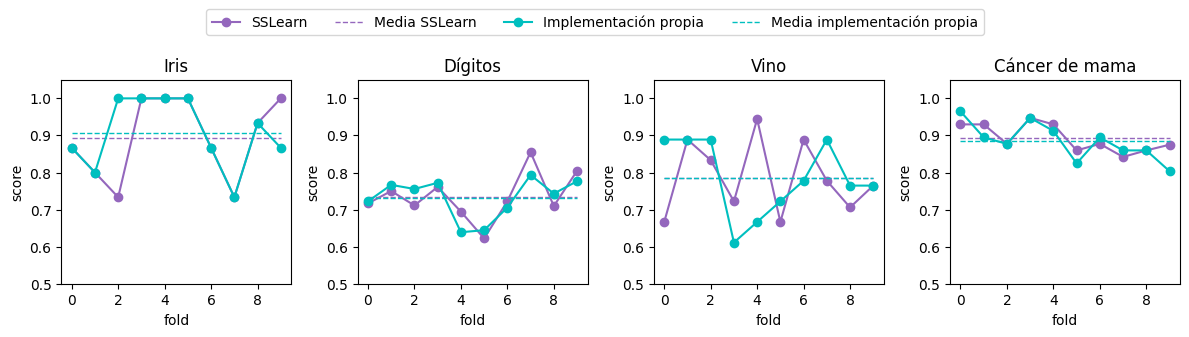

In [25]:
def graph_score_fold_sslearn(algorithm = 'TT', rd_number = 5):

    labels = ['SSLearn', 'Media SSLearn', 'Implementación propia', 'Media implementación propia']
    rd = np.random.RandomState(rd_number)
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,3), tight_layout=True)
    available = [   (load_iris(return_X_y=True), 'Iris'),
                    (load_digits(return_X_y=True), 'Dígitos'),
                    (load_wine(return_X_y=True),  'Vino'),
                    (load_breast_cancer(return_X_y=True), 'Cáncer de mama')]
    i = 0

    for dataset in available:

        X, y = dataset[0]
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)
        results = []
        results_mine = []

        for train_index, test_index in skf.split(X, y):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            X_train_labels, y_train_labels, U, U_labels = artificial_ssl_dataset(X_train, y_train, label_rate=0.1)

            # SSLearn
            model = TriTrainingSSLearn().fit(X_train_labels, y_train_labels)
            results.append(model.score(X_test, y_test))
            
            # Mio (misma función que usa él internamente)
            model_mine = TriTraining(DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier())
            X_mine, y_mine, U_mine = get_dataset(X_train_labels, y_train_labels)
            model_mine.fit(X_mine, y_mine, U_mine)
            results_mine.append(model_mine.score(X_test, y_test))

        ax_i = ax[i]
        ax_i.set_ylim([0.5, 1.05])

        mean = np.mean(results)
        ax_i.plot(results, '-o', color = '#9467bd')
        ax_i.plot([mean for i in range(10)], '--', linewidth=1, color = '#9467bd')

        mean = np.mean(results_mine)
        ax_i.plot(results_mine, 'c-o')
        ax_i.plot([mean for i in range(10)], 'c--', linewidth=1)

        ax_i.set_ylabel('score')
        ax_i.set_xlabel('fold')
        ax_i.set_title(dataset[1])
        i += 1
    
    fig.legend(labels, bbox_to_anchor=(0.5, 1.0), loc='lower center', ncol=4) 
    plt.plot()
    

graph_score_fold_sslearn()

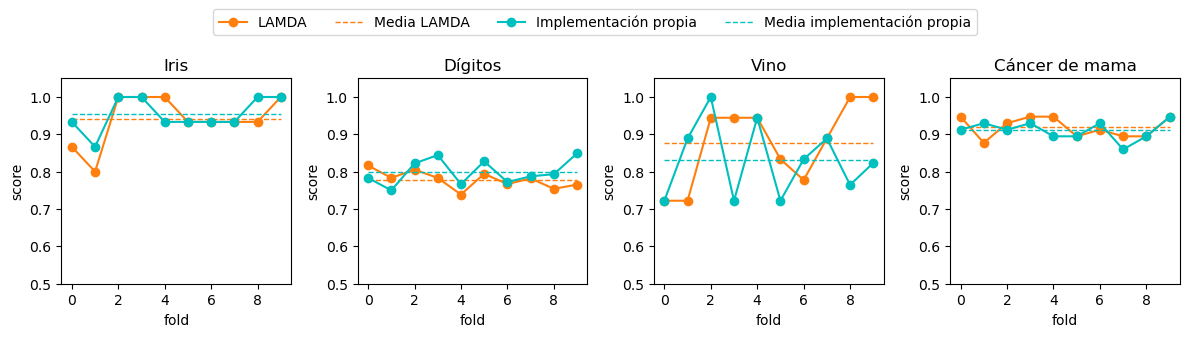

In [15]:
def graph_score_fold_lamda(algorithm = 'TT', rd_number = 5):

    labels = ['LAMDA', 'Media LAMDA', 'Implementación propia', 'Media implementación propia']
    rd = np.random.RandomState(rd_number)
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,3), tight_layout=True)
    available = [   (load_iris(return_X_y=True), 'Iris', 0), 
                    (load_digits(return_X_y=True), 'Dígitos', 1), 
                    (load_wine(return_X_y=True), 'Vino', 2), 
                    (load_breast_cancer(return_X_y=True), 'Cáncer de mama', 3)]

    for dataset in available:

        X, y = dataset[0]
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)
        results = []
        results_mine = []

        for train_index, test_index in skf.split(X, y):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            L_train, U_train, Ly_train, Uy_train = train_test_split(X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)

            # LAMDA
            model = TriTrainingLamda(DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier())
            model.fit(L_train, Ly_train, U_train)
            results.append(model.score(X_test, y_test))
            
            # Mio (misma función que usa él internamente)
            model_mine = TriTraining(DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier())
            model_mine.fit(L_train, Ly_train, U_train)
            results_mine.append(model_mine.score(X_test, y_test))

        ax_i = ax[dataset[2]]
        ax_i.set_ylim([0.5, 1.05])

        mean = np.mean(results)
        ax_i.plot(results, '-o', color = '#ff7f0e', label = dataset[1])
        ax_i.plot([mean for i in range(10)], '--', color = '#ff7f0e', linewidth=1)

        mean = np.mean(results_mine)
        ax_i.plot(results_mine, 'c-o', label = dataset[1])
        ax_i.plot([mean for i in range(10)], 'c--', linewidth=1)

        ax_i.set_ylabel('score')
        ax_i.set_xlabel('fold')
        ax_i.set_title(dataset[1])
    
    fig.legend(labels, bbox_to_anchor=(0.5, 1.0), loc='lower center', ncol=4) 
    plt.plot()

graph_score_fold_lamda()

-------------------------------------------------------
# **RUN ALL** 🏃🏼‍♀️

In [ ]:
def run_all(algorithm = 'CF'):  
    
    # results = graphs_keel("iris/iris-ssl-", 5, 'CF')
    # print("IRIS vs KEEL: {}, mean: {}".format(results, np.mean(results)))

    # results = graphs_keel("wine/wine-ssl10-10-", 10, 'CF')
    # print("WINE vs KEEL: {}, mean: {}".format(results, np.mean(results)))

    graph_score_iterations_train(algorithm)
    graph_score_iterations_train_dsv(algorithm)

    graph_number_elem_training_time(algorithm)
    score_percentage_training_instances(algorithm)

    if algorithm == 'CF':
        graph_coforest_score_time()

In [ ]:
#run_all('TT') #'CF', 'TT, 'DC'   